In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

<b>Переобучение</b> (overfitting) - ситуация, при которой результативность модели на обучающей выборке значительно превосходит таковую на общих данных (тестовая выборка). <br>
<b>Недообучение</b> (underfitting) - ситуация, при которой модель не показывает приемлемых результатов даже на обучающей выборке.

Почему происходит переобучение? Для этого рассмотрим процесс с формальной стороны. Обучаемую модель можно охарактеризовать тремя основными компонентами: <br>
1) Пространство гипотез (представление). Это множество всех функций, которые могут быть представлены данной моделью. Например, в модели линейной регрессии, это пространство включает в себя различные линейные функции от m переменных, где m - размерность данных. В модели деревьев решений - множество деревьев, получаемое в результате различных вариантов разбиений и заданных ограничений (максимальная высота дерева, минимальное число данных в поддеревьях и т.п.).
<br> 
2) Критерий оценки модели, позволяющий предпочесть одну гипотезу другой. Стоит учитывать, что критерий, используемой моделью, может отличаться от того критерия, который мы стремимся оптимизировать. Например, в задаче классификации внутренним критерием может являться кросс-энтропия предсказанного распределения вероятности над классами с эталонным распределением, в то время, как фактически, мы стремимся чтобы модель как можно чаще предсказывала верный класс. <br>
3) Оптимизация - алгоритм, при помощи которого из пространства гипотез выбирается наиболее подходящая (или они все оцениваются с точки зрения правдопобности).

Источник: https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf

Следовательно, чтобы модель переобучилась, должна быть выбрана гипотеза, которая хорошо работает на данных для обучения, однако плохо показывает себя за пределами этой выборки.

Рассмотрим простой пример:

In [2]:
regression_data = pd.DataFrame({'x': [0, 1, 2., 3, 4], 'y':[5, 2.6, 1., 3.2, 4.7]})

In [3]:
regression_data

,x,y
0,0.0,5.0
1,1.0,2.6
2,2.0,1.0
3,3.0,3.2
4,4.0,4.7


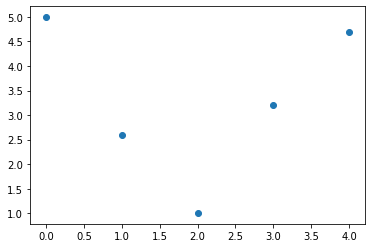

In [4]:
plt.scatter(regression_data.x, regression_data.y)

Исходя из этой таблицы и того, что искомая функция является гладкой, мы можем предложить бесконечное количество решений (функций от x), точно или достаточно близко совпадающих с данными.
Предположим, что искомая функция является полиномом n-й степени и выведем наиболее подходящие гипотезы для различных n.

In [5]:
def powers_of(x, begin, end):
    powers = []
    for i in range(begin, end+1):
        powers.append(x ** i)
    return np.column_stack(powers)

In [6]:
X_powers = powers_of(regression_data.x, 1, 5)

In [7]:
pd.DataFrame(X_powers, columns=np.arange(1,6))

,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,2.0,4.0,8.0,16.0,32.0
3,3.0,9.0,27.0,81.0,243.0
4,4.0,16.0,64.0,256.0,1024.0


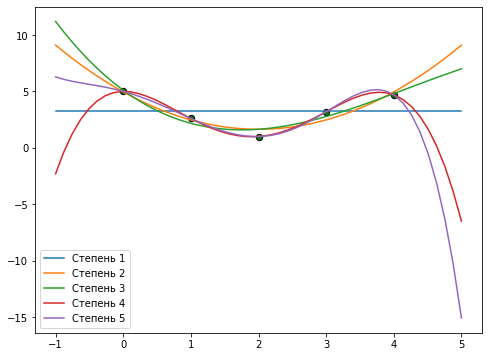

In [53]:
plt.figure(figsize=(8,6))
x_range = np.linspace(-1, 5)
x_range_powers = powers_of(x_range, 1, 5)

plt.scatter(regression_data.x, regression_data.y, s=40, marker='o', c='green', edgecolors='black')
for i in range(1, 6):
    lreg = LinearRegression().fit(X_powers[:,:i], regression_data.y)
    pred = lreg.predict(x_range_powers[:,:i])
    plt.plot(x_range, pred, label='Степень {}'.format(i))
plt.legend()
plt.show()

Какие наблюдения можно отсюда вынести?
<br>

Практически все модели, кроме первой, проводят полином очень близко к точкам, модели 4-й и 5-й степени - проводят его ровно через точки. Подобно тому, как через 2 точки проходит только одна прямая, через 3 проходит только одна парабола, через n - полином n-1 степени. Однако, если степень полинома равна или превышает число точек, точно проходящих полиномов становится бесконечное количество. В частности, существует бесконечное множество полиномов 5й степени, ровно проходящих через точки на графике.

Какая из этих моделей верная - вообще говоря, мы не можем сказать. Мы не видели остальных точек. Можно с уверенностью сказать, что это не модель 5, потому что вероятность, что случайно взятый полином 5й степени, точно проходящий через точки, является искомым - равна нулю. Однако та или иная модель может быть близкой к правде или далекой от неё, и это куда более жизнеспособный критерий. Например, мы не знаем точного значения гравитационной постоянной, но тем не менее, классический закон тяготения обладает значительной предсказательной силой. 

Может ли быть так, что модель 1 ближе к правде, чем остальные? Вполне возможно. Нужно учитывать, что значение $y$ не обязательно зависит от $x$ или зависит только от $x$. Ошибка модели, не связанная с её неточностью, а происходящая от случайных факторов или факторов, с которыми она незнакома, называется <b>несократимой ошибкой</b>. В таком случае, $y$ можно представить как сумму значения истинной закономерности $f(x)$ и случайного шума $\epsilon$ (сумма неучтенных факторов), среднее значение которого равно нулю:
$$y = f(x) + \epsilon$$

Наша задача заключается в поиске подходящего приближения $\hat{f}(x)$ к $f(x)$. Лучшее, что мы может сделать с ненаблюдаемыми факторами - это настроить модель так, чтобы в среднем они суммировались в ноль. Модель 1 именно это и делает, путем настройки свободного коэффициента $b$ (смещения).

### Составляющие ошибки модели
Ошибку обучаемой модели (не конкретной уже обученной) на общих данных можно разложить на три компонента:
* Несократимая ошибка - ошибка связанная с недостаточностью данных для точного предсказания
* Смещение модели - ожидаемая ошибка модели, независящая от того, какая выборка использовалась в качестве обучающей.
* Дисперсия модели - насколько модель изменяет свои предсказания в зависимости от выборки, использованной для обучения.

П. Домингос в статье <a href="https://homes.cs.washington.edu/~pedrod/papers/mlc00a.pdf">"A Unified Bias-Variance Decomposition and its Applications"</a> формализует и обобщает эти понятия через использование функции потерь.

Пусть имеется тестовый экземпляр данных $(x,t)$, где $x$ - входные данные, $t$ - истинный ответ. <br>
Модель, в зависимости от использованных для тренировки данных, предсказывает ответ $y$. <br>
Функция потерь $L$ замеряет, насколько данный ответ отклоняется от эталонного. Т.е. $L(t, y) = 0$  если  $y = t$.<br>
Для регрессии можно использовать критерий MSE $(t-y)^2$ <br>
Для классификации можно критерий 0-1. $L(t,y)$ = 0, если $y=t$, и 1 в противном случае. Отметим, что обычно классификаторы не обучаются на этой функции, поскольку она недифференцируема, но мы можем свободно использовать её в нашем анализе.

Обозначим через $D$ множество возможных обучающих выборок.
Основным предсказанием модели для данных $x$ называется величина:
$$y_m = \underset{y'}{\operatorname{argmin}}\mathbb{E}_D[L(y, y')]$$
Т.е. это величина, для которой отклонение (по $L$) от предсказания на $x$, полученного после обучения модели на случайно взятой обучающей выборке из $D$, в среднем минимально. <br>
В такой формулировке, $y_m$ для регрессии (при использовании MSE) равно среднему предсказанию на данных $x$ по всем обучающим выборкам. Для классификации $y_m$ - это наиболее часто встречающее предсказание (мода) на $x$ по всем обучающим выборкам.

Рассмотрим это всё на примере. Сгенерируем данные для классификации используя формулу:
$$z = |x|-|y| + \mathcal{N}(0,1)$$
$$y = 1~ \text{if}~z \ge 0~\text{else}~0$$

где $\mathcal{N}(0,1)$ - случайный шум, распределенный нормально вокруг нуля со среднеквадратичным отклонением 1

In [54]:
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)

xx, yy = np.meshgrid(x, y)

In [55]:
def true_curve(x,y):
    return np.abs(x) - np.abs(y)

In [56]:
zz = true_curve(xx,yy)

In [57]:
%matplotlib notebook

In [58]:
from mpl_toolkits.mplot3d import Axes3D

Отобразим зависимость $z$ от $x$ и $y$ (без шума)

<IPython.core.display.Javascript object>


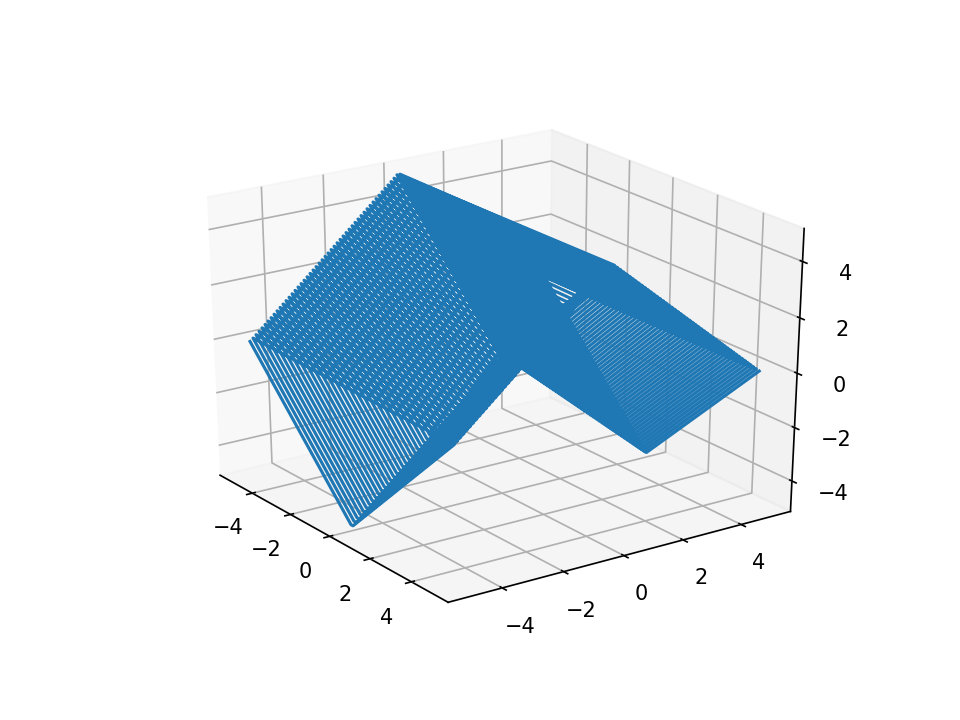

In [59]:
fig = plt.figure()
ax = fig.add_subplot('111', projection='3d')
ax.plot(xx.ravel(),yy.ravel(),zz.ravel())
plt.show()

Отобразим границу принятия решений (z = 0), которая отделяет экзмпляры класса 0 от класса 1. Классификатор, использующий данную формулу без шума является оптимальным, в том смысле, что он корректно описывает зависимость класса от $x$ и $y$. С шумом он ничего не может сделать.

In [60]:
%matplotlib inline

In [61]:
from matplotlib import cm, colors

In [62]:
cmap = colors.ListedColormap(['blue','green'])

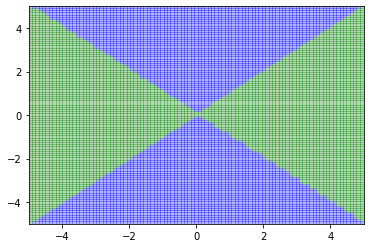

In [63]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.pcolormesh(xx,yy, zz >= 0, cmap=cmap, alpha=0.3)

Сгенерируем данные для обучения и тестирования, используя формулу генерации с шумом.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
from sklearn.metrics import zero_one_loss

In [21]:
np.random.seed(7117)

In [22]:
X_test = np.column_stack([_.ravel() for _ in np.mgrid[-5:5:50j, -5:5:50j]])
y_test = true_curve(X_test[:,0], X_test[:,1]) + np.random.normal(0,1,size=X_test.shape[0])
y_test = (y_test >= 0).astype(np.int32)

In [23]:
print(len(y_test))

2500


Отделим случайные 500 экземпляров для обучения

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=2000)

In [25]:
training_set_size=120

Из этих 500 экземпляров мы будем случайно сэмплировать обучающие выборки по 120 экземпляров. Всего возьмем 100 выборок. На основе этого оценим смещение и дисперсию классификаторов.

In [28]:
training_sets = [np.random.choice(500, size=training_set_size, replace=False) for _ in range(100)]

Построим оптимальный классификатор

In [64]:
class TrueClassifier():
    def fit(self, X,y):
        return self
    
    def predict(self, X):
        return (true_curve(X[:,0], X[:,1]) >= 0).astype(np.int32)
#         return  (2 * np.tanh(X[:,0]) + X[:,1]**3 - 1 >= 0).astype(np.int32)
    
true_classfier = TrueClassifier()

In [30]:
true_pred = true_classfier.predict(X_test)

Даже он ошибается в 13.5 процентах случаев из-за шума

In [31]:
print(zero_one_loss(y_test, true_pred))

0.13449999999999995


In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
import scipy.stats

Вычислим смещение и дисперсию классификатора.
Смещение классификатора на экземпляре $x$ вычисляется по формуле:
$$\text{bias}=\mathbb{E}_D L(y^*,y')$$
Т.е. это отклонение от оптимального предсказания, усредненное по множеству обучающих выборок. Оптимальное предсказание нам известно для любого $x$ (потому что данные синтетические). Ожидаемое значение отклонения приблизим следующим образом: 
1. Обучим классификаторы на каждой из 100 случайных обучающих выборок.
2. Для каждого классификатора вычислим предсказание $y'$ для выбранного $x$ и вычислим отклонение $L(y^*, y')$
3. Вычислим среднее этих отклонений.

Это было смещение на одном экземпляре данных $x$. Мы также можем вычислить <b>среднее смещение</b> классификатора, вычислив смещение на всех $x$ и взяв среднее. Эту величину мы будем называть просто смещением классификатора.

Поскольку на практике мы не знаем оптимального классификатора, данную формулу трудно применить. Мы можем оценить смещение таким же способом, как описано, но заменив $y^*$ на $t$ - истинное предсказание на данных $x$. Замеренное таким образом смещение, как правило, будет переоценено, но тем не менее выполняет свое функцию - <i>оценивает ожидаемую ошибку модели, не зависящую от того, на какой обучающей выборке она была обучена</i>. 

Дисперсия модели на данных $x$ замеряется как среднее отклонение по $L$ предсказания $y'$ модели от основного предсказания $y_m$ модели на этих данных. Таким образом, дисперсия замеряет чувствительность модели к изменению обучающей выборки. Модели с низкой дисперсию выучивают примерно одну и ту же функцию, независимо от выбранной обучающей выборки. Модели с высокой дисперсией могут значительно изменять выбранную гипотезу при добавлении, удалении или изменении всего нескольких экземпляров данных.

Формально:
$$\text{variance} = \mathbb{E}_D L(y_m, y')$$
Средняя дисперсия модели вычисляется как мат. ожидание дисперсии на экземплляре по всем экземплярам. Аналогично вычислению смещения, её можно приблизить, сэмплируя обучающие выборки и усредняя полученные дисперсии на экземплярах.


Упрощенно - смещение модели говорит о её тенденции совершать одну и ту же ошибку независимо от данных, на которых она была натренирована. Дисперсия же говорит о тенденции модели делать случайные ошибки, в зависимости от использованных для обучения данных. 
Они обычно соотносятся с недообучением и переобучением. Модель с высоким смещением, как правило, не в состоянии хорошо показать себя даже на обучающих данных, поскольку её пространство гипотез не включает в себя функций, хорошо аппроксимирующих искомую. Пример - попытка выучить линейную модель, когда истинная функция значительно нелинейна.

Модель с высокой дисперсией, как правило, имеет слишком широкое пространство гипотез, в котором множество функций хорошо аппроксимируют тренировочные данные, но могут быть совершенно непохожи на искомую. Таким образом мы приходим к переобучению. Например, через 9 точек лежащей на одной прямой (истинная гипотеза) можно провести бесконечное число полиномов 9й степени и выше. 

<img src="bias_variance_shoot.png" width=400>

In [34]:
def compute_bias_variance(classifier, training_sets_indices, optimal_labels):
    predictions = []
    for indices in training_sets_indices:
        xx_train, yy_train = X_train[indices], y_train[indices]
        clf = classifier()
        clf.fit(xx_train, yy_train)
        predictions.append(clf.predict(X_test))
    predictions = np.array(predictions)
    main_predictions = scipy.stats.mode(predictions, axis=0)[0][0]
    print(main_predictions)
    bias_with_noise = zero_one_loss(y_test, main_predictions)
    bias = zero_one_loss(optimal_labels, main_predictions)
    variances = np.array([zero_one_loss(main_predictions, pred) for pred in predictions])
    variance = variances.mean()
    
    print('bias', bias)
    print('bias-with-noise', bias_with_noise)
    print('variance', variance)
    
    return bias, bias_with_noise, variance
    

Оценим смещение и дисперсию дефолтной логистической регрессии sklearn на ранее сгенерированных данных.

In [65]:
res = compute_bias_variance(lambda: LogisticRegression(solver='lbfgs'), training_sets, true_pred)    

[0 0 0 ... 0 0 0]
bias 0.6045
bias-with-noise 0.6
variance 0.359775


Результат ожидаемый - данные не являются линейно разделяемыми, поэтому классификатор неизбежно ошибается, как его не тренируй. В зависимости от особенностей обучающей выборки, выбирается разный линейный разделитель, что также связано с тем, что размер обучающей выборки - всего 120 экземпляров.

Замерим эти же величину у классификатора 5 ближайших соседей

In [36]:
res = compute_bias_variance(lambda: KNeighborsClassifier(n_neighbors=5), training_sets, true_pred)

[1 1 1 ... 0 0 0]
bias 0.06399999999999995
bias-with-noise 0.15749999999999997
variance 0.11594499999999998


Этот классификатор способен выучить куда более сложные функции, чем логистическая регрессия, но плохоприменим в многомерных пространствах, требуя все больше и больше экземпляров данных для работоспособности.

Оптимальный классификатор, очевидно, независим от обучающей выборки, и имеет нулевое смещение, ибо это отклонение от оптимального классификатора.

In [37]:
res = compute_bias_variance(lambda: TrueClassifier(), training_sets, true_pred)

[1 1 0 ... 0 0 0]
bias 0.0
bias-with-noise 0.13449999999999995
variance 0.0


In [38]:
from sklearn.preprocessing import PolynomialFeatures

Мы также может построить логистическую регрессию поверх полиномиальных признаков. Модель ниже использует разделитель формы:
$$w_1x + w_2y + w_3xy + w_4x^2 + w_5y^2 + b = 0$$

In [39]:
class PolynomialLogistic:
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, include_bias=False)
        self.logr = LogisticRegression(solver='lbfgs')
        
    def fit(self, X, y):
        features = self.poly.fit_transform(X)
        self.logr.fit(features,y)
        return self
    
    def predict(self, X):
        features = self.poly.transform(X)
        return self.logr.predict(features)

Можно заметить, что его показания на тестовой выборке достаточно хорошие

In [40]:
res = compute_bias_variance(lambda: PolynomialLogistic(), training_sets, true_pred)

[0 1 0 ... 0 0 0]
bias 0.04849999999999999
bias-with-noise 0.14100000000000001
variance 0.05540500000000001


In [41]:
logr = PolynomialLogistic().fit(X_train[:200], y_train[:200])

In [42]:
print(zero_one_loss(y_test, logr.predict(X_test)))

0.13749999999999996


Натренируем его на случайной выборке. Нарисуем его границу принятия решений. Полученная граница относительно близка к оптимальной.

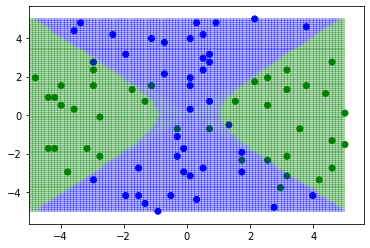

In [68]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.pcolormesh(xx,yy, zz >= 0, cmap=cmap, alpha=0.1)
ax.scatter(X_test[:80,0], X_test[:80,1], marker='o', c=y_test[:80],cmap=cmap)

grp = logr.predict(np.column_stack([xx.ravel(), yy.ravel()]))
ax.pcolormesh(xx,yy, grp.reshape(xx.shape), cmap=cmap, alpha=0.2)
plt.show()